
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# アダム

:ラベル: `sec_adam`

このセクションに至るまでの議論で、効率的な最適化のための多くのテクニックに遭遇しました。ここで詳しくまとめてみましょう。
-  :numref: `sec_sgd`冗長データに対する固有の復元力などにより、最適化問題を解決する場合に勾配降下法よりも効果的であることがわかりました。
-  :numref: `sec_minibatch_sgd` 1 つのミニバッチでより大きな観測セットを使用することにより、ベクトル化によって大幅な追加の効率を提供することがわかりました。これは、効率的なマルチマシン、マルチ GPU、および全体的な並列処理の鍵となります。
-  :numref: `sec_momentum`収束を加速するために過去の勾配の履歴を集約するメカニズムを追加しました。
-  :numref: `sec_adagrad`計算効率の高い前処理を可能にするために座標ごとのスケーリングを使用しました。
-  :numref: `sec_rmsprop`座標ごとのスケーリングを学習率調整から切り離しました。

 Adam :cite: `Kingma.Ba.2014`これらすべてのテクニックを 1 つの効率的な学習アルゴリズムに組み合わせています。予想通り、これはディープ ラーニングで使用するためのより堅牢で効果的な最適化アルゴリズムの 1 つとしてかなり人気のあるアルゴリズムです。ただし、問題がないわけではありません。特に、:cite: `Reddi.Kale.Kumar.2019` 、分散制御が不十分なために Adam が発散する可能性がある状況があることを示しています。フォローアップ作業で、:citet: `Zaheer.Reddi.Sachan.ea.2018` 、これらの問題に対処する Yogi と呼ばれるホットフィックスを Adam に提案しました。これについては後で詳しく説明します。ここでは、Adam アルゴリズムを確認してみましょう。

## アルゴリズム

Adam の重要なコンポーネントの 1 つは、指数加重移動平均 (漏洩平均とも呼ばれる) を使用して、運動量と勾配の 2 次モーメントの両方の推定値を取得することです。つまり、状態変数を使用します。

 $$\begin{aligned} \mathbf{v} *t &amp; \leftarrow \beta_1 \mathbf{v}* {t-1} + (1 - \beta_1) \mathbf{g} *t, \ \mathbf{s}_t &amp; \leftarrow \beta_2 \mathbf{s}* {t-1} + (1 - \beta_2) \mathbf{g}_t^2。 \end{整列}$$

ここで $\beta_1$ と $\beta_2$ は非負の重み付けパラメーターです。一般的な選択肢は、$\beta_1 = 0.9$ および $\beta_2 = 0.999$ です。つまり、分散推定値は運動量項よりも*はるかにゆっくりと*動きます。 $\mathbf{v} *0 = \mathbf{s}_0 = 0$ を初期化すると、最初は小さい値に向かってかなりの量のバイアスがかかることに注意してください。これは、$\sum {i=0}^{t-1} \beta^i = \frac{1 - \beta^t}{1 - \beta}$ という事実を利用して項を再正規化することで対処できます。* 。同様に、正規化された状態変数は次のように与えられます。

 $$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ および } \hat{\mathbf{s}}_t = \frac{ \mathbf{s}_t}{1 - \beta_2^t}.$$

適切な推定値が得られたら、更新方程式を書き出すことができます。まず、RMSProp とよく似た方法で勾配を再スケーリングして、次の値を取得します。

 $$\mathbf{g}_t&#39; = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

 RMSProp とは異なり、更新では勾配自体ではなく運動量 $\hat{\mathbf{v}}_t$ を使用します。さらに、再スケーリングは $\frac{1}{\sqrt の代わりに $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ を使用して行われるため、外観に若干の違いがあります。 {\hat{\mathbf{s}}_t + \epsilon}}$。前者の方が実際にはおそらくわずかにうまく機能するため、RMSProp からの逸脱があります。通常、数値の安定性と忠実性の間の適切なトレードオフを考慮して $\epsilon = 10^{-6}$ を選択します。

これで、更新を計算するためのすべての要素が整いました。これは少しクライマックスに反したもので、フォームを簡単に更新します。

 $$\mathbf{x} *t \leftarrow \mathbf{x}* {t-1} - \mathbf{g}_t&#39;.$$

アダムのデザインを見直すと、そのインスピレーションが明らかです。勢いとスケールは状態変数にはっきりと表示されます。それらのかなり独特な定義により、用語をバイアスしなければなりません (これは、初期化と更新の条件を少し変えることで修正できる可能性があります)。次に、RMSProp を考慮すると、両方の項の組み合わせは非常に簡単です。最後に、明示的な学習率 $\eta$ を使用すると、ステップ長を制御して収束の問題に対処できます。

## 実装

Adam を最初から実装するのはそれほど難しいことではありません。便宜上、タイム ステップ カウンター $t$ を`hyperparams`ディクショナリに保存します。それ以上はすべて簡単です。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1


Adam を使用してモデルをトレーニングする準備ができました。 $\eta = 0.01$ の学習率を使用します。


loss: 0.242, 0.172 sec/epoch


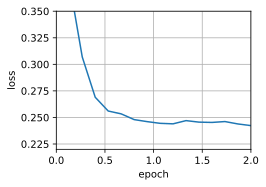

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);


`adam` Gluon `trainer`最適化ライブラリの一部として提供されるアルゴリズムの 1 つであるため、より簡潔な実装は簡単です。したがって、Gluon での実装の構成パラメータを渡すだけで済みます。


loss: 0.245, 0.149 sec/epoch


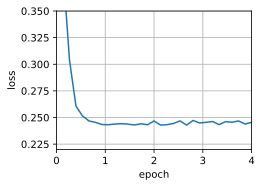

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)


## ヨギ

Adam の問題の 1 つは、$\mathbf{s}_t$ の 2 番目のモーメント推定値が爆発すると、凸設定でも収束に失敗する可能性があることです。修正として :citet: `Zaheer.Reddi.Sachan.ea.2018`は、$\mathbf{s}_t$ の改良された更新 (および初期化) を提案しました。何が起こっているのかを理解するために、Adam の更新を次のように書き直してみましょう。

 $$\mathbf{s} *t \leftarrow \mathbf{s}* {t-1} + (1 - \beta_2) \left(\mathbf{g} *t^2 - \mathbf{s}* {t-1}\右).$$

 $\mathbf{g} *t^2$ の分散が大きい場合、または更新がまばらな場合、$\mathbf{s}_t$ は過去の値をすぐに忘れてしまう可能性があります。*これを修正するには、$\mathbf{g}_t^2 - \mathbf{s} {t-1}$ を $\mathbf{g} *t^2 \odot \mathop{\mathrm{sgn}}**に置き換えることが考えられます。* *(\mathbf{g}_t^2 - \mathbf{s}* {t-1})$。現在、更新の大きさは偏差の量に依存しなくなりました。これによりYogiのアップデートが行われます

$$\mathbf{s} *t \leftarrow \mathbf{s}* {t-1} + (1 - \beta_2) \mathbf{g} *t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{ g}_t^2 - \mathbf{s}* {t-1}).$$

著者らはさらに、単に最初の点ごとの推定ではなく、より大きな初期バッチで運動量を初期化することをアドバイスしています。詳細は議論にとって重要ではないため、また、この収束がなくてもかなり良好なままであるため、省略します。


loss: 0.244, 0.152 sec/epoch


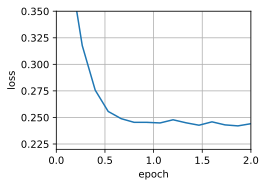

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);


## まとめ
- Adam は、多くの最適化アルゴリズムの機能を組み合わせて、かなり堅牢な更新ルールを作成します。
-  RMSProp に基づいて作成された Adam は、ミニバッチの確率的勾配で EWMA も使用します。
-  Adam は、バイアス補正を使用して、勢いと 2 番目のモーメントを推定する際の遅い起動を調整します。
- 分散が大きい勾配の場合、収束に関して問題が発生する可能性があります。これらは、より大きなミニバッチを使用するか、$\mathbf{s}_t$ の改善された推定値に切り替えることによって修正できます。 Yogi はそのような代替案を提供します。

## 演習
1. 学習率を調整し、実験結果を観察および分析します。
1. バイアス補正を必要としないように、勢いとセカンドモーメントの更新を書き換えることはできますか?
1. 収束するにつれて学習率 $\eta$ を下げる必要があるのはなぜですか?
1. アダムが発散し、ヨギが収束するケースを組み立ててみませんか?



[ディスカッション](https://discuss.d2l.ai/t/1078)
